In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!unzip '/content/drive/My Drive/523_pipeline/output_image_24000.zip' -d '/content/drive/My Drive/523_pipeline/output_image_24000'
#!unzip '/content/drive/My Drive/523_pipeline/output_image_latest(1).zip' -d '/content/drive/My Drive/523_pipeline/output_image_latest(1)'

In [2]:
generated_dir = '/content/drive/My Drive/523_pipeline/output_image/generated'
ground_truth_dir = '/content/drive/My Drive/523_pipeline/output_image/ground_truth'

In [6]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os

# Load a pre-trained ResNet model
model = models.resnet50(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Define a transform to preprocess the image
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to load an image and transform it
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Convert image to RGB
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function to extract features using the PyTorch model
def extract_features(input_image, model):
    with torch.no_grad():  # Ensure no gradients are calculated
        features = model(input_image)
    return features

# Initialize the list to store the similarity score for each ground truth image
scores = []

# Loop through each ground truth image
for i in range(302):
    gt_img_path = os.path.join(ground_truth_dir, f'ground_truth_progress_{i}.png')
    gen_img_path = os.path.join(generated_dir, f'generated_progress_{i}.png')

    # Load and process both images
    gt_image_tensor = load_image(gt_img_path)
    gen_image_tensor = load_image(gen_img_path)

    # Extract features
    gt_features = extract_features(gt_image_tensor, model)
    gen_features = extract_features(gen_image_tensor, model)

    # Calculate cosine similarity
    similarity = torch.nn.functional.cosine_similarity(gen_features, gt_features, dim=1).item()

    # Store the similarity score
    scores.append(similarity)

# At this point, 'scores' contains the similarity scores for each corresponding pair of images
print(scores)



[0.37733399868011475, 0.26708608865737915, 0.460163950920105, 0.7141993641853333, 0.6402111053466797, 0.5954501628875732, 0.3495928645133972, 0.565473198890686, 0.4904365539550781, 0.6632726192474365, 0.6547502279281616, 0.6538529992103577, 0.711892306804657, 0.5576865673065186, 0.5333662629127502, 0.4526509642601013, 0.34068506956100464, 0.6584687829017639, 0.636735200881958, 0.6904368996620178, 0.4537864029407501, 0.5671263933181763, 0.6458410024642944, 0.6296281218528748, 0.46251267194747925, 0.5085029006004333, 0.7066693902015686, 0.5693633556365967, 0.6724196076393127, 0.5067421197891235, 0.39186763763427734, 0.5282443165779114, 0.5212311744689941, 0.6972224712371826, 0.25385066866874695, 0.5462678670883179, 0.4434446692466736, 0.6820488572120667, 0.6207491159439087, 0.2663208842277527, 0.6746603846549988, 0.5383947491645813, 0.6642612218856812, 0.6350407600402832, 0.59224534034729, 0.5019834041595459, 0.7118309140205383, 0.6312919855117798, 0.7087460160255432, 0.49483975768089294

In [7]:
scores

[0.37733399868011475,
 0.26708608865737915,
 0.460163950920105,
 0.7141993641853333,
 0.6402111053466797,
 0.5954501628875732,
 0.3495928645133972,
 0.565473198890686,
 0.4904365539550781,
 0.6632726192474365,
 0.6547502279281616,
 0.6538529992103577,
 0.711892306804657,
 0.5576865673065186,
 0.5333662629127502,
 0.4526509642601013,
 0.34068506956100464,
 0.6584687829017639,
 0.636735200881958,
 0.6904368996620178,
 0.4537864029407501,
 0.5671263933181763,
 0.6458410024642944,
 0.6296281218528748,
 0.46251267194747925,
 0.5085029006004333,
 0.7066693902015686,
 0.5693633556365967,
 0.6724196076393127,
 0.5067421197891235,
 0.39186763763427734,
 0.5282443165779114,
 0.5212311744689941,
 0.6972224712371826,
 0.25385066866874695,
 0.5462678670883179,
 0.4434446692466736,
 0.6820488572120667,
 0.6207491159439087,
 0.2663208842277527,
 0.6746603846549988,
 0.5383947491645813,
 0.6642612218856812,
 0.6350407600402832,
 0.59224534034729,
 0.5019834041595459,
 0.7118309140205383,
 0.6312919855

In [8]:
len(scores)

302

In [9]:
average_score = sum(scores) / len(scores)
average_score

0.5530789241885508

In [10]:
text_dir = '/content/drive/My Drive/523_pipeline/output_image/text'

In [11]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import os

# Initialize CLIP model and processor
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

def calculate_text_image_correlation(image_path, text):
    image = Image.open(image_path).convert('RGB').resize((256, 256))
    inputs = processor(text=[text], images=image, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    similarity = torch.nn.functional.cosine_similarity(outputs.text_embeds, outputs.image_embeds, dim=1)
    return similarity.item()

# List to store the similarity score for each ground truth image and corresponding text
text_scores = []

# Assume 'text_dir' and 'generated_dir' are defined and have paths set up correctly
# Loop through each text file (302 total)
for i in range(302):
    text_path = os.path.join(text_dir, f'text_progress_{i}.txt')
    gen_img_path = os.path.join(generated_dir, f'generated_progress_{i}.png')

    # Read the text from the file
    with open(text_path, 'r') as file:
        text = file.read()

    # Calculate the similarity between the text and the corresponding single generated image
    similarity = calculate_text_image_correlation(gen_img_path, text)

    # Store the similarity score
    text_scores.append(similarity)

# Now 'text_scores' contains the similarity scores for each ground truth and its corresponding text
print(text_scores)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

[0.3240568935871124, 0.3376029133796692, 0.33517423272132874, 0.32139432430267334, 0.3600912392139435, 0.31054452061653137, 0.30902883410453796, 0.3958856761455536, 0.30726858973503113, 0.33337271213531494, 0.3475123345851898, 0.33985796570777893, 0.3092666268348694, 0.3112325966358185, 0.40056782960891724, 0.30723437666893005, 0.37322160601615906, 0.3500188887119293, 0.3445192575454712, 0.3009684383869171, 0.3228985369205475, 0.27514347434043884, 0.3421313762664795, 0.33487361669540405, 0.2973211705684662, 0.2668726146221161, 0.3721314072608948, 0.34301280975341797, 0.35085251927375793, 0.3012445271015167, 0.3574508726596832, 0.32633325457572937, 0.3462240397930145, 0.2902032732963562, 0.31933876872062683, 0.3063686788082123, 0.33191919326782227, 0.27827882766723633, 0.33984509110450745, 0.31672099232673645, 0.3863629698753357, 0.3201742172241211, 0.2684616148471832, 0.3159576952457428, 0.27784618735313416, 0.29611891508102417, 0.3702385127544403, 0.3267761170864105, 0.299776107072830

In [12]:
text_scores

[0.3240568935871124,
 0.3376029133796692,
 0.33517423272132874,
 0.32139432430267334,
 0.3600912392139435,
 0.31054452061653137,
 0.30902883410453796,
 0.3958856761455536,
 0.30726858973503113,
 0.33337271213531494,
 0.3475123345851898,
 0.33985796570777893,
 0.3092666268348694,
 0.3112325966358185,
 0.40056782960891724,
 0.30723437666893005,
 0.37322160601615906,
 0.3500188887119293,
 0.3445192575454712,
 0.3009684383869171,
 0.3228985369205475,
 0.27514347434043884,
 0.3421313762664795,
 0.33487361669540405,
 0.2973211705684662,
 0.2668726146221161,
 0.3721314072608948,
 0.34301280975341797,
 0.35085251927375793,
 0.3012445271015167,
 0.3574508726596832,
 0.32633325457572937,
 0.3462240397930145,
 0.2902032732963562,
 0.31933876872062683,
 0.3063686788082123,
 0.33191919326782227,
 0.27827882766723633,
 0.33984509110450745,
 0.31672099232673645,
 0.3863629698753357,
 0.3201742172241211,
 0.2684616148471832,
 0.3159576952457428,
 0.27784618735313416,
 0.29611891508102417,
 0.370238512

In [13]:
average_text_score = sum(text_scores) / len(text_scores)
average_text_score

0.3339213267560826

In [14]:
len(text_scores)

302

In [16]:
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import torch
import os

# Initialize the InceptionV3 model
model = models.inception_v3(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Define image transformation
transform = transforms.Compose([
    transforms.Resize(299),  # Resize the image to fit the input size of the model
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# List of image file paths
image_files = sorted([os.path.join(generated_dir, f) for f in os.listdir(generated_dir) if f.endswith('.png')])

# List to store the confidence scores for each image
image_quality_score = []

# Process each image individually
for image_path in image_files:
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add a batch dimension

    # Get model prediction and confidence
    with torch.no_grad():
        outputs = model(image)
        _, predicted = outputs.max(1)
        confidence = torch.nn.functional.softmax(outputs, dim=1)[0, predicted].item()

    # Store the confidence score
    image_quality_score.append(confidence)

# Print or return the list of confidence scores
print(image_quality_score)


[0.269750714302063, 0.24997243285179138, 0.3018856942653656, 0.05615213140845299, 0.06204570457339287, 0.22755412757396698, 0.6770528554916382, 0.2079910784959793, 0.2326713651418686, 0.12595859169960022, 0.03712538629770279, 0.2084932178258896, 0.4242999255657196, 0.2498912662267685, 0.08329684287309647, 0.07875517755746841, 0.37722712755203247, 0.4293702244758606, 0.1606401950120926, 0.4504728317260742, 0.38732603192329407, 0.06207209825515747, 0.25324755907058716, 0.6639536023139954, 0.06194840371608734, 0.9133114814758301, 0.13854359090328217, 0.24895623326301575, 0.3309043347835541, 0.5796207189559937, 0.15606270730495453, 0.14471237361431122, 0.04830726236104965, 0.512321412563324, 0.09378357231616974, 0.2586010694503784, 0.14887560904026031, 0.217431902885437, 0.08314013481140137, 0.19914402067661285, 0.8524660468101501, 0.4559687376022339, 0.6097978949546814, 0.10616564750671387, 0.6692031025886536, 0.17297840118408203, 0.6582773923873901, 0.05879263952374458, 0.297592610120773

In [17]:
average_text_score = sum(image_quality_score) / len(image_quality_score)
average_text_score

0.3116037794103732

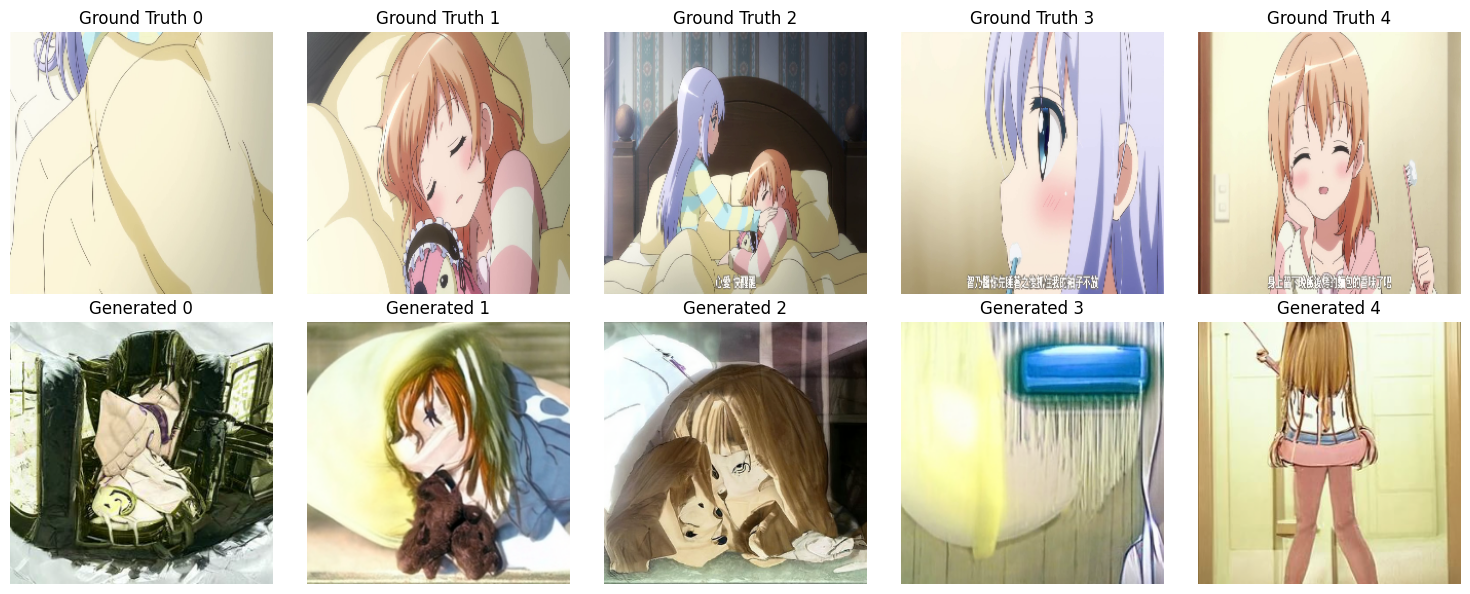

In [18]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Setup matplotlib figure
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))  # 2 rows, 5 columns
axes = axes.ravel()  # Flatten the axes array for easier indexing

# Load and display the images
for i in range(5):  # Display the first five images
    # Ground truth images
    gt_path = os.path.join(ground_truth_dir, f'ground_truth_progress_{i}.png')
    gt_image = Image.open(gt_path)
    axes[i].imshow(gt_image)
    axes[i].set_title(f'Ground Truth {i}')
    axes[i].axis('off')

    # Generated images
    gen_path = os.path.join(generated_dir, f'generated_progress_{i}.png')
    gen_image = Image.open(gen_path)
    axes[i + 5].imshow(gen_image)  # Offset by 5 to place on the second row
    axes[i + 5].set_title(f'Generated {i}')
    axes[i + 5].axis('off')

plt.tight_layout()
plt.show()


In [5]:
import torch
from torchvision import models, transforms
from PIL import Image
import os
import numpy as np
from scipy.linalg import sqrtm

# Initialize InceptionV3 model
try:
    from torchvision.models import inception_v3, InceptionV3_Weights
    model = inception_v3(weights=InceptionV3_Weights.IMAGENET1K_V1).eval()
except ImportError:
    model = models.inception_v3(pretrained=True).eval()
model.fc = torch.nn.Identity()
model.cuda()

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_features(image_paths):
    features = []
    for image_path in image_paths:
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0).cuda()
        with torch.no_grad():
            feature = model(image).cpu().numpy()
        features.append(feature.squeeze())
    return np.array(features)

def calculate_fid(features1, features2, eps=1e-6):
    mu1, sigma1 = np.mean(features1, axis=0), np.cov(features1, rowvar=False)
    mu2, sigma2 = np.mean(features2, axis=0), np.cov(features2, rowvar=False)

    # Regularize the covariance matrices by adding a small value `eps` to the diagonals
    sigma1 += np.eye(sigma1.shape[0]) * eps
    sigma2 += np.eye(sigma2.shape[0]) * eps

    ssdiff = np.sum((mu1 - mu2) ** 2)
    try:
        covmean = sqrtm(sigma1.dot(sigma2))
        if np.iscomplexobj(covmean):
            covmean = covmean.real
    except Exception as e:
        print(f"Error computing sqrtm: {e}")
        return float('nan')  # Return NaN to indicate failure

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid


# Get image paths
generated_image_paths = [os.path.join(generated_dir, f'generated_progress_{i}.png') for i in range(302)]
ground_truth_image_paths = [os.path.join(ground_truth_dir, f'ground_truth_progress_{i}.png') for i in range(302)]

# Extract features
generated_features = extract_features(generated_image_paths)
ground_truth_features = extract_features(ground_truth_image_paths)

# Calculate FID
fid_score = calculate_fid(generated_features, ground_truth_features)

# Output FID score
print("FID Score:", fid_score)


FID Score: 164.92052017411422
